## Importing the goodies

In [0]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import os
import cv2 
from PIL import Image
from tqdm import tnrange, tqdm_notebook
import numpy as np
from numpy import moveaxis
import torch
from torch.utils.data.sampler import Sampler
from torch.utils.data import TensorDataset 
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn                                                
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
import Augmentor
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)

import time

## First step- extracting training data from the timelapse
* This involves trimming the timelapse into four parts 
* Then extracting all the frames from the trimmed videos to be converted to numpy arrays

In [0]:
def trim_video(source_path, start_time, end_time, target_path):
    ffmpeg_extract_subclip(source_path, start_time, end_time, targetname=target_path)

In [0]:
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 32, end_time = 82, target_path = ROOT + "split_labels/gastrula.mp4")
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 116, end_time = 126, target_path = ROOT + "split_labels/comma.mp4")
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 140, end_time = 187, target_path = ROOT + "split_labels/fold.mp4")
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 224, end_time = 240, target_path = ROOT + "split_labels/l1.mp4")



[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 32.00 -t 50.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/gastrula.mp4
... command successful.

[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 116.00 -t 10.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/comma.mp4
... command successful.

[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 140.00 -t 47.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/fold.mp4
... command successful.

[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 224.00 -t 16.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/l1.mp4
... command successful.


In [0]:
def videos_to_frames(video_path, new_folder_path):
    # os.mkdir(new_folder_path)
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = new_folder_path + "/" + str(count)+ ".jpg"
        try:
            cv2.imwrite(fmt_name, image)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", new_folder_path)

In [0]:
videos_to_frames(ROOT + "split_labels/gastrula.mp4", new_folder_path = ROOT + "frames/gastrula")
videos_to_frames(ROOT + "split_labels/comma.mp4", new_folder_path = ROOT + "frames/comma")
videos_to_frames(ROOT + "split_labels/fold.mp4", new_folder_path = ROOT + "frames/fold")
videos_to_frames(ROOT + "split_labels/l1.mp4", new_folder_path = ROOT + "frames/l1")

saved  730  frames at  /content/drive/My Drive/kaggle/GSOC/frames/gastrula
saved  140  frames at  /content/drive/My Drive/kaggle/GSOC/frames/comma
saved  555  frames at  /content/drive/My Drive/kaggle/GSOC/frames/fold
saved  97  frames at  /content/drive/My Drive/kaggle/GSOC/frames/l1


## Balancing training data using augmentation


In [0]:
def augment_images(source_folder, num_images):
    p = Augmentor.Pipeline(source_folder)
    p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=5)
    p.flip_left_right(probability=0.7)
    p.flip_top_bottom(probability=0.7)
    p.sample(num_images)

In [0]:
def augment_images_resize(source_folder, num_images, new_width, new_height):
    p = Augmentor.Pipeline(source_folder)
    p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=5)
    p.flip_left_right(probability=0.7)
    p.flip_top_bottom(probability=0.7)
    p.rotate(probability=0.8, max_left_rotation=24, max_right_rotation=15)

    p.resize(probability=1.0, width=new_width, height=new_height)
    p.sample(num_images)


def augment_images_from_folders(paths_list, num_per_category, width, height):
    for i in paths_list:
        print ("saving from -- ", i)
        augment_images_resize(i, num_per_category, width, height )

In [0]:
frames_paths = [ 
                ROOT + "frames/gastrula/",
                ROOT + "frames/comma/",
                ROOT + "frames/fold/",
                ROOT + "frames/l1/"
                ]
augment_images_from_folders(frames_paths, 500, 60, 30)

saving from --  /content/drive/My Drive/kaggle/GSOC/frames/gastrula/


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 750 image(s) found.
Output directory set to /content/drive/My Drive/kaggle/GSOC/frames/gastrula/output.

Processing <PIL.Image.Image image mode=RGB size=60x30 at 0x7F6070E13F98>: 100%|██████████| 500/500 [00:11<00:00, 44.12 Samples/s]


saving from --  /content/drive/My Drive/kaggle/GSOC/frames/comma/


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 150 image(s) found.
Output directory set to /content/drive/My Drive/kaggle/GSOC/frames/comma/output.

Processing <PIL.Image.Image image mode=RGB size=60x30 at 0x7F6064697BA8>: 100%|██████████| 500/500 [00:11<00:00, 44.14 Samples/s]


saving from --  /content/drive/My Drive/kaggle/GSOC/frames/fold/


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 370 image(s) found.
Output directory set to /content/drive/My Drive/kaggle/GSOC/frames/fold/output.

Processing <PIL.Image.Image image mode=RGB size=60x30 at 0x7F606F00B3C8>: 100%|██████████| 500/500 [00:11<00:00, 44.14 Samples/s]


saving from --  /content/drive/My Drive/kaggle/GSOC/frames/l1/


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 237 image(s) found.
Output directory set to /content/drive/My Drive/kaggle/GSOC/frames/l1/output.

Processing <PIL.Image.Image image mode=RGB size=60x30 at 0x7F6064638128>: 100%|██████████| 500/500 [00:11<00:00, 43.95 Samples/s]


## Generating training data from saved frames
* img_to_arr() takes in the path of an image and returns a numpy array of the image, moveaxis() is optional depending on whether we want to feed it to a CNN or to simply just show it.
* Keep moveaxis = False when you want to plot and view it, or moveaxis = True when it needs to be used for training data


In [0]:
def img_to_arr(im_path, move_axis = True):
    try:
        x = cv2.imread(im_path, 0) 
    except:
        return
    # x = np.array(img)
    if move_axis == True:
        x = moveaxis(x, 2, 0)
    x = x.astype(float)
    return x

def generate_train_data(source_folder, save_path, filename,  label = 0):
    save_path = save_path + filename
    final_stack = []
    c = 0
    for i in tqdm_notebook(os.listdir(source_folder)):   
        
        im_path = source_folder + "/" + i
        im_arr = img_to_arr(im_path, move_axis = False)
        stack_element = [im_arr, label]
        stack_element = np.array(stack_element)
        final_stack.append(stack_element)

    final_stack = np.array(final_stack)
    fmt_name = save_path
    np.save(fmt_name, final_stack)
    print ("saved -- ", fmt_name)

def view_samples_from_training_data(arr, skip_val):
    images = []
    for i in range (0,len(arr), skip_val):
        foo = arr[i][0]
        images.append(foo)
    f = plt.figure(figsize = (25,20))
    for m in range (1,len(images)):
        f.add_subplot(1,len(images), m)
        plt.imshow(images[m])
    plt.show()

def load_numpy_arrays(paths_list):
    s = []
    for i in paths_list:
        s.append(np.array(np.load( i , allow_pickle = True)))
    arr = np.vstack(tuple(j for j in s))
    del s
    return arr

## Save all the frames with labels from the folders as numpy arrays
* These portable numpy arrays can be wrapped with the TensorDataset wrapper for training the CNN



In [0]:
generate_train_data(ROOT + "frames/resized/gastrula_smol/", ROOT +  "numpy/", "gastrula_smol.npy",  label = 0)
generate_train_data(ROOT + "frames/resized/comma_smol/", ROOT +  "numpy/", "comma_smol.npy",  label = 1)
generate_train_data(ROOT + "frames/resized/fold_smol/", ROOT + "numpy/", "fold_smol.npy",  label = 2)
generate_train_data(ROOT + "frames/resized/l1_smol/", ROOT + "numpy/", "l1_smol.npy",  label = 3)


saved --  /content/drive/My Drive/kaggle/GSOC/numpy/gastrula_smol.npy



saved --  /content/drive/My Drive/kaggle/GSOC/numpy/comma_smol.npy



saved --  /content/drive/My Drive/kaggle/GSOC/numpy/fold_smol.npy



saved --  /content/drive/My Drive/kaggle/GSOC/numpy/l1_smol.npy


## Loading up the training data 


In [0]:
smol_paths = [
            ROOT + "numpy/gastrula_smol.npy",
            ROOT + "numpy/comma_smol.npy",
            ROOT + "numpy/fold_smol.npy", 
            ROOT + "numpy/l1_smol.npy"
              ]

big_paths = [
            ROOT + "numpy/gastrula.npy",
            ROOT + "numpy/comma.npy",
            ROOT + "numpy/fold.npy", 
            ROOT + "numpy/l1.npy"
            ]
arr_smol = load_numpy_arrays(smol_paths)
arr_big = load_numpy_arrays(big_paths)


## Viewing a sample from each of the four categories. 


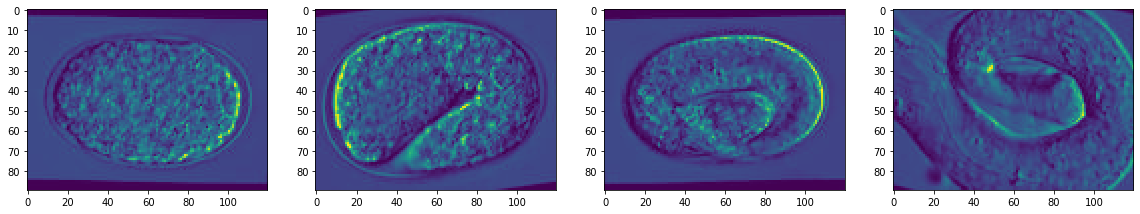

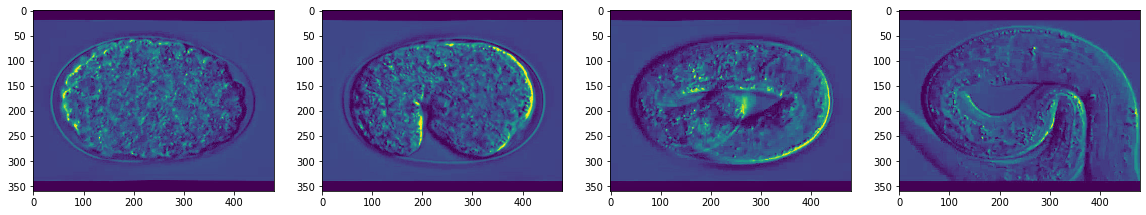

In [11]:
view_samples_from_training_data(arr_smol, 401)
view_samples_from_training_data(arr_big, 400)

## Splitting training data into images and labels 
* and defining `vis_loss_multi_colors()` , which is basically a poor man's  tensorboard
* try keeping a small batch size, preferably below 64
* a smaller batch size causes noisy updates, but can result in faster learning and a more robust model
* `preprocess_to_tensors_for_training()` converts the loaded np.array to a DataLoader object with the given batch size.

In [0]:
def extract_column(arr, index):
    x_train = []
    for m in range (len(arr)):
        x_train.append(arr[m][index])
    return(np.array(x_train))

def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()

def preprocess_to_tensors_for_training(np_array, batch_size):

    x_train = extract_column(np_array,0)
    y_train = extract_column(np_array,1)
    x_train_tensor = torch.from_numpy(x_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    full_dataset = TensorDataset(x_train_tensor, y_train_tensor)    ## make compatible with DataLoader 
    train_size = int(0.9 * len(full_dataset))  ## 90/10 split
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle = True)
    print(len(train_loader), "batches ")
    print(len(val_loader), " batches ")

    return train_loader, val_loader

In [164]:
train_loader_smol, val_loader_smol = preprocess_to_tensors_for_training(arr_smol, 36)
train_loader_big, val_loader_big = preprocess_to_tensors_for_training(arr_big, 36)

50 batches 
50  batches 
50 batches 
50  batches 


## Defining the NN architecture
* Larger pool size for max pooling was used because the classifying factors spanned over a relatively larger area, and not in the fine details


In [173]:
def build_cnn():

    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1, 10, 3)
            self.pool = nn.MaxPool2d(5,5)

            self.pool2 = nn.MaxPool2d(3,3)
            self.dropout = nn.Dropout(p=0.5)
            self.conv2 = nn.Conv2d(10, 10, 3)
            self.conv3 = nn.Conv2d(10, 10, 3)
            
            self.fc1 = nn.Linear(150, 110)
            self.fc2 = nn.Linear(110, 100)
            self.fc3 = nn.Linear(100, 4)

        def forward(self, x):
            x = (self.pool(F.relu(self.conv1(x))))
            x = self.pool2(F.relu(self.conv2(x)))
            x = F.relu(self.conv3(x))

            x = x.view(x.size(0), -1)
            
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = (self.fc3(x))      ## removed relu
            return x
build_cnn()
cellnet = Net()
print(cellnet)

optimizer = optim.Adam(cellnet.parameters(), lr = 0.0009) 
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)  # lr decreases by 1% aftr every epoch


Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=150, out_features=110, bias=True)
  (fc2): Linear(in_features=110, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=4, bias=True)
)


## defining the training loop and some lists to collect training metrics
* `StepLR()` decays the learning rate by certain factor gamma after each epoch. It helps prevent random spikes in validation and training loss after the initial few epochs
* `calculate_accuracy_on_validation_set()` works with Dataloader objects, feel free to pass batches through it


In [0]:
def calculate_accuracy_on_validation_set(val_loader):
    cellnet.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in val_loader:
            x_val, y_val = batch
            x_val = x_val.view(-1, 1, x_val.size()[1], x_val.size()[2])        # if torch tensor
            pred = cellnet(x_val)  # pred
            scores = ([i.item() for i in (torch.eq(torch.argmax(pred,dim = 1).float(), y_val))])
            for m in scores:
                total+= 1 
                if m == True:
                    correct +=1 
        acc = (correct/total)*100
        return acc

def train_step(x, y):
        optimizer.zero_grad()
        x = x.view(-1, 1, x.size()[1], x.size()[2])        # if torch tensor
        pred = cellnet(x)
        y = y.long()
        loss = F.cross_entropy(pred,y)
        loss.backward()
        optimizer.step()        
        return loss.item()

def train(epochs, train_loader, val_loader):
    start = time.process_time()
    losses = []
    val_losses = []

    for m in range (epochs):
        clear_output()
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in val_loader:
                y_val =  y_val.long()
                x_val = x_val.view(-1, 1, x_val.size()[1], x_val.size()[2])        # if torch tensor
                yhat =cellnet(x_val)  # pred 
                val_loss = F.cross_entropy(yhat, y_val)
                val_losses.append(val_loss.item())  ## metrics 
        cellnet.train()
        
        
        for x_batch, y_batch in tqdm_notebook(train_loader, desc = " Training batches : "):
                loss = train_step(x_batch, y_batch)
                losses.append(loss)
        scheduler.step()   ## lr decay caller 

    clear_output()
    vis_loss_multi_colors(losses, val_losses)
    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses, val_losses

## First, we train the CNN on smaller images for 2 epochs
* smaller images means faster forward passes and overall a faster training time
* they'll help give the CNN a good start when it has to train on the larger images

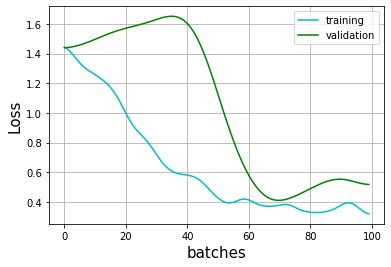

Time elapsed =  12.839231444999996  seconds


In [167]:
losses, val_losses = train(2, train_loader_smol, val_loader_smol)

## After 2 epochs on the smaller images, we get an accuracy of about 87%
* it actually peaks at 92% if we train it for 5 more epochs, but for our example, 2 epochs would be enough.

In [159]:
print ("Accuracy = ", calculate_accuracy_on_validation_set(val_loader_smol), "%")

Accuracy =  87.0 %


## Freezing all the layers except for the first 2  linear layers
* The shape of the first linear layer was changed to accomodate the forward pass of a larger image (hence a larger tensor)
* The shape of the second layer was changed to prevent an overly abrupt change in size

In [0]:
cellnet.conv1.weight.requires_grad = False
cellnet.conv1.bias.requires_grad = False

cellnet.conv2.weight.requires_grad = False
cellnet.conv2.bias.requires_grad = False

cellnet.conv3.weight.requires_grad = False
cellnet.conv3.bias.requires_grad = False

cellnet.fc1 = nn.Linear(6090, 500)  ## reshaping 2 linear layers to accomodate forward pass
cellnet.fc2 = nn.Linear(500, 100)

cellnet.fc3.weight.requires_grad = False
cellnet.fc3.bias.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, cellnet.parameters()), lr=0.0008)


## Training just the new larger linear layers 
* All the other layers are frozen, so the training takes considerably less time.
* Backpropagation only occurs only on the 2 larger linear layers

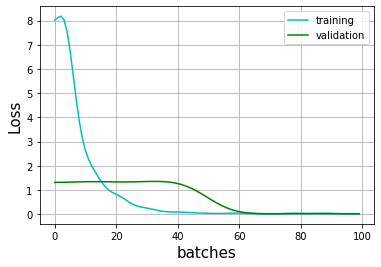

Time elapsed =  88.58741176600006  seconds


In [169]:
losses_2, val_losses_2 = train(2, train_loader_big, val_loader_big)
losses.extend(losses_2)
val_losses.extend(val_losses_2)

## Accuracy on the test set jumps from 87% to 98% in just 2 epochs
* Achieving 99% accuracy on the large images alone would've take more epochs and hence more time to train.

* The spike that we see in the plot above is because the the 2 new linear layers were untrained, but they got trained pretty fast ( with 2 epochs)

In [162]:
print ("Accuracy = ", calculate_accuracy_on_validation_set(val_loader_big), "%")

Accuracy =  98.0 %


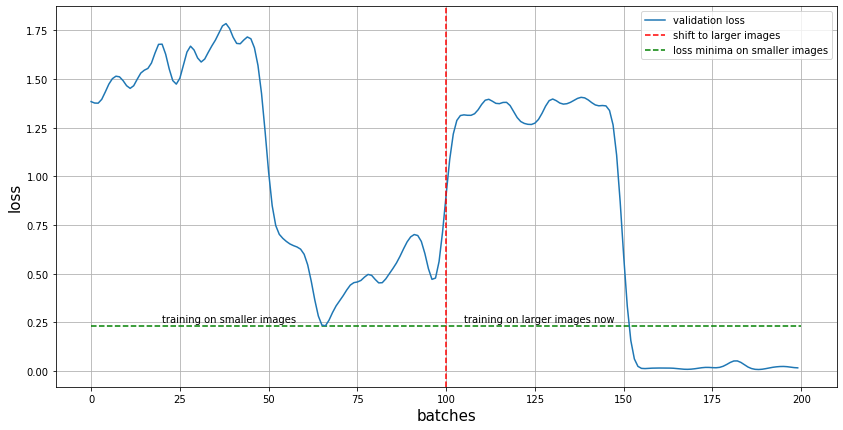

In [179]:
ysmoothed = gaussian_filter1d(val_losses, sigma=2)
plt.figure(figsize=(14,7))
plt.plot(ysmoothed, label = "validation loss")
plt.hlines(min(ysmoothed[:100]), 0, len(val_losses), linestyle = "--", colors= "green", label = "loss minima on smaller images")
plt.axvline(x=100, color = "red", linestyle = "--", label = "shift to larger images")
plt.text(105, 0.25, r'training on larger images now', fontsize=10)
plt.text(20, 0.25, r'training on smaller images', fontsize=10)

plt.xlabel("batches", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.grid()
plt.legend()
plt.show()

## Now let's see how long it takes for the same architecture to reach high accuracies without transfer learning
* all the weights would reset and the CNN would now train only on the larger images


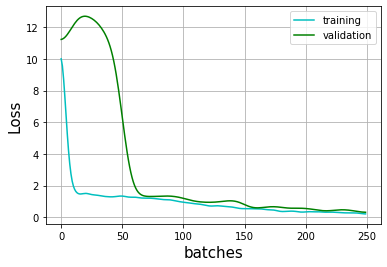

Time elapsed =  485.42653092  seconds


In [175]:
build_cnn()
cellnet.fc1 = nn.Linear(6090, 500)  ## reshaping 2 linear layers to accomodate forward pass
cellnet.fc2 = nn.Linear(500, 100)
losses_big, val_losses_big = train(5, train_loader_big, val_loader_big)


### It took the CNN about 100 seconds to reach 98% accuracy with transfer learning, while it took 485 seconds to reach 86.5% without transfer learning 
* with transfer learning with image resizing it took one fourth of the time to reach a higher accuracy

In [176]:
print ("Accuracy = ", calculate_accuracy_on_validation_set(val_loader_big), "%")

Accuracy =  86.5 %
